In [31]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg
%matplotlib inline
matplotlib.pylab.rcParams['figure.figsize']= 16,5

In [32]:
data = np.genfromtxt('Resources/data.csv', delimiter=',')
d_mean = np.mean(data)
d_std = np.std(data)
data = (data - d_mean) / d_std

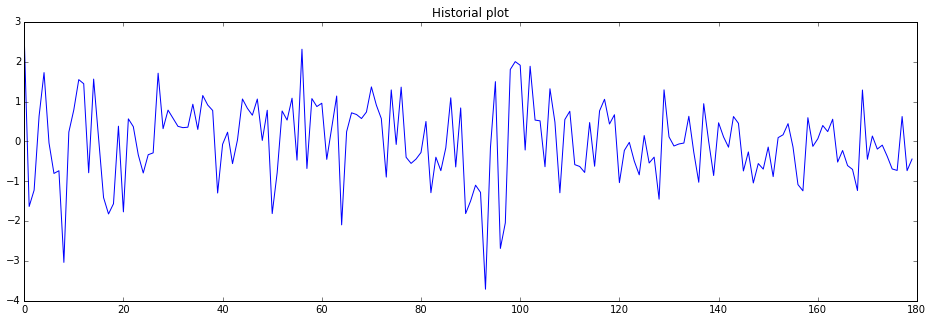

In [33]:
figure(1)
plot(data)
title('Historial plot')

Defining Initial parameters

In [34]:
trainLen =len(data) - 6
testLen = 6
initLen = 12

In [35]:
# generate the ESN reservoir
inSize = outSize = 1
resSize = 10
a = 0.95 # leaking rate

In [36]:
random.seed(42)

Generating Win for matrix of in coefficients

In [37]:
# for this code, we create the W-in matrix, whit shape (resSize, 1+inSize) and it will be filled with the weigths of the conecctions from
# the inputs to the reservoir nodes (neurons), It's important to remember that we add '1' to the inputs as the interceptor.
# the function rand sample the range [0,1] in a uniform distribution, so we subtract 0.5 to obtain a uniform distribution for the range [-0.5,0.5]
# At the least we scale the matrix, in this case with 1.
# This matrix is dense, here are no one zero element. Sparsity it's a parameter we can change to improve the ESN
Win = (random.rand(resSize,1+inSize)-0.5) * 1

Generation W for coefficients matrix of reservoir nodes

In [38]:
# for this code, we create the W matrix, whit shape (resSize, inSize) and it will be filled with the weigths of the conecctions from
# the inputs to the reservoir nodes (neurons).
# the function rand sample the range [0,1] in a uniform distribution, so we subtract 0.5 to obtain a uniform distribution for the range [-0.5,0.5]
# This matrix is dense, here are no one zero element. Sparsity it's a parameter we can change to improve the ESN
W = random.rand(resSize,resSize)-0.5

Getting the Spectral Radious

In [39]:
rhoW = max(abs(linalg.eig(W)[0]))

In [40]:
#the SRR (Spectral Radious Rescaling Factor) it's used to scale the spectral radious to obtain a value < 1. 
# This ensures the echo state property, but it can be more in some inputs  
SRR = 1.25
W*=SRR/ rhoW

Generation the matrix for echo states

In [41]:
# This matrix X is the one where we will save the states for every neuron (except the output(s) neuron(s)) at every training step except 
# the initial ones.
# The matrix Y is for saving the true outputs at every point in the time. 
X = zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1]

Running reservoir with data to generate states (X matrix)

In [42]:
#this script fill matrix X with all the activation states
#First, create the vector to save actual activations of reservoir nodes
x = zeros((resSize,1))
#For every data point in the training data
for t in range(trainLen):
    #We get the data in step t 
    u = data[t]
    # we get the update for x. First it the hiperbolic tangent of  the dot product of Win and the input data and 
    # the dot product of W and the reservoir activation vector  x(t-1) as x_t
    x_u = tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    x = (1-a)*x + a*x_u 
    if t >= initLen:
        X[:,t-initLen] = vstack((1,u,x))[:,0]

Training the output

In [43]:
# in this point we train the output layer (the only one that will be trained). For addressing overfiting we use a L2 normalization named 
# 'ridge regression' penaltying large weights, sympthoms of overfitting 
reg = 1e-8  # regularization coefficient
X_T = X.T #Transpose matrix X
#in this line we get the Wout trained weights, by doing a dot product between the dot product of the Target Values Yt and transpose matrix X,
#  and the inverse of the dot product of X by X transposed adding the penalty 
Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + \
    reg*eye(1+inSize+resSize) ) )

Generating readouts with validate data

In [44]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    y = dot( Wout, vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1]

In [45]:
Y

In [27]:
Y1 = (Y * d_std) + d_mean

In [1]:
Y1

NameError: name 'Y1' is not defined

In [29]:
plot(Y1[0])

In [30]:
Wout

array([[-0.00143347, -0.00188225, -0.00486264, ..., -0.00016113,
        -0.00065063, -0.00792599]])